CLuster analysis is a method of grouping, or clustering, consumers based on their similarities. 
two primary types of cluster analysis leveraged in market segmentation: 
    hierarchical cluster analysis
    partitioning(k-mean)
For this one, we use K-means clustering analysis to segment the groups. 

In [1]:
import gc
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from IPython.display import Image

from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv(r'c:\\Users\\wangc\\Desktop\\Chloe Wang\\2. Customer Segmentation\\Online Retail.csv', delimiter=';', decimal=',')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## Processing Data

In [4]:
# drop cancelled orders 
df = df.loc[df['Quantity'] > 0]

# drop record without CustomerId
df = df[pd.notnull(df['CustomerID'])]

# drop incomplete month
df = df.loc[df['InvoiceDate'] < '2011-12-01']

# calculate total sales from the Quantity and UnitPrice
df['Sales'] = df['Quantity'] * df['UnitPrice']

# use groupby to aggregate sales by CustomerId
customer_df = df.groupby('CustomerID').agg({'Sales':sum, 
                                            'InvoiceNo': lambda x: x.nunique() })

# select the columns we want to use
customer_df.columns = ['TotalSales', 'OrderCount']

# create a new column 'AvgOrderValu'
customer_df['AvgOrderValue'] = customer_df['TotalSales'] / customer_df['OrderCount']

customer_df

C:\Users\wangc\AppData\Local\Temp\ipykernel_29656\3214092469.py:14: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  customer_df = df.groupby('CustomerID').agg({'Sales':sum,


,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600
12347.0,584.91,1,584.910
12348.0,892.80,1,892.800
12350.0,334.40,1,334.400
12352.0,1767.73,5,353.546
...,...,...,...
18277.0,110.38,1,110.380
18281.0,80.82,1,80.820
18282.0,77.84,1,77.840


In [5]:
# Drop cancelled orders
df = df.loc[df['Quantity'] > 0]

# Drop records without CustomerID
df = df[pd.notnull(df['CustomerID'])]

# Drop incomplete month
df = df.loc[df['InvoiceDate'] < '2011-12-01']

# Calculate total sales from the Quantity and UnitPrice
df['Sales'] = df['Quantity'] * df['UnitPrice']

# use groupby to aggregate sales by CustomerID
customer_df = df.groupby('CustomerID').agg({'Sales': sum, 
                                            'InvoiceNo': lambda x: x.nunique()})

# Select the columns we want to use
customer_df.columns = ['TotalSales', 'OrderCount'] 

# create a new column 'AvgOrderValu'
customer_df['AvgOrderValue'] = customer_df['TotalSales'] / customer_df['OrderCount']

customer_df.head()

C:\Users\wangc\AppData\Local\Temp\ipykernel_29656\4151822763.py:14: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  customer_df = df.groupby('CustomerID').agg({'Sales': sum,


,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600
12347.0,584.91,1,584.910
12348.0,892.80,1,892.800
12350.0,334.40,1,334.400
12352.0,1767.73,5,353.546


##### nuniuqe & unique
nunique: return the number of unique values in a Series
unique: return an array of the unique values in a Series

Importance of normalization\standardization for data used in K-means clustering.
If your variables are of incomparable units (heights and weights) then you should standardize variables. Even if variables are of the same units but show quite different variances it is still a good idea to standardize before k-means. 
Because k-means clustering is 'isotropic' in all directions of space and therefore tends to produce more or less round clusters. In this situation leaving variances unequal is equivalent to putting more weight on vairances with smaller variance, so clusters will tend to be separated along variables with greater variances.  

In [6]:
rank_df = customer_df.rank(method='first') # ranking across all columns from 1 - max() 
normalized_df = (rank_df - rank_df.mean()) / rank_df.std()
normalized_df.head(10)

,TotalSales,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,1.727732,-1.731187,1.731187
12347.0,0.252249,-1.730035,1.218627
12348.0,0.665753,-1.728883,1.488153
12350.0,-0.435388,-1.727732,0.334028
12352.0,1.241663,1.269307,0.463032
12353.0,-1.592968,-1.726580,-1.539985
12356.0,1.393703,-0.005759,1.604487
12358.0,0.035706,-1.725428,1.014754
12359.0,1.535377,-0.004607,1.670140


Model building - determining how many clusters we want to use
1) sihouette coefficient 
    -- Measure how similar an object is to its own cluster(cohesion) compared to other clusters(separation). -- score close to 1 indicate that the samples are well clusterd. 0 means the samples are close; -1 means the samples might have been assigned to the wrong clusters. 
    1) compute the average distance between each point and all other points in the same cluster(a)
    2) compute the average distance between each point and all other points in the next nearest cluster(b)
    3) silhouette score = (b-a)/max(a,b)
    4) average the silhouette socres over all samples
2) the elbow method
    1) calculate within-cluster sum of square. distance between data points to the center within each cluster

In [7]:
# sihouette coefficient 
from sklearn.metrics import silhouette_score
for n_cluster in [4,5,6,7,8]:
    kmeans = KMeans(n_clusters=n_cluster).fit(
        normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']])
    
    silhouette_avg = silhouette_score(
        normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']],
        kmeans.labels_) # label the cluster of the sample belong
    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

c:\Users\wangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for 4 Clusters: 0.4163
Silhouette Score for 5 Clusters: 0.3886


c:\Users\wangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\wangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for 6 Clusters: 0.3747
Silhouette Score for 7 Clusters: 0.3820


c:\Users\wangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\wangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for 8 Clusters: 0.3691


c:\Users\wangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\wangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\wangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\wangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\clus

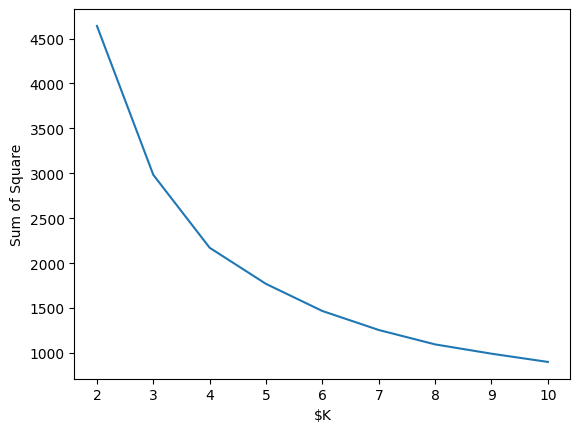

In [8]:
# the elbow method
from sklearn import cluster
import numpy as np

sse = [] # sum of squared errors
krange = list(range(2,11)) # range of k values
X = normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']].values
for n in krange:
    model = cluster.KMeans(n_clusters=n, random_state=3) # random_state=seed
    model.fit_predict(X)
    cluster_assignments = model.labels_
    centers = model.cluster_centers_
    sse.append(np.sum((X - centers[cluster_assignments]) ** 2)) # ** square | calculate within cluster sum of squares(WCSS)
    # computes WCSS value to the 'sse' list, which keeps track of the SSD for each number of sum of squares
plt.plot(krange, sse)
plt.xlabel("$K")
plt.ylabel("Sum of Square")
plt.show()

Base on the plot above, K = 4 is the optimal number of clusters for this dataset. 

In [9]:
kmeans = KMeans(n_clusters = 4).fit(normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']])
 
four_cluster_df = normalized_df[['TotalSales', 'OrderCount', 'AvgOrderValue']].copy(deep=True)
four_cluster_df['Cluster'] = kmeans.labels_

four_cluster_df.head()

c:\Users\wangc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,TotalSales,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,1.727732,-1.731187,1.731187,2
12347.0,0.252249,-1.730035,1.218627,2
12348.0,0.665753,-1.728883,1.488153,2
12350.0,-0.435388,-1.727732,0.334028,2
12352.0,1.241663,1.269307,0.463032,3


In [10]:
# Group the cluster metrics and see what we can gather from the normalized data for each cluster

cluster1_metrics = kmeans.cluster_centers_[0]
cluster2_metrics = kmeans.cluster_centers_[1]
cluster3_metrics = kmeans.cluster_centers_[2]
cluster4_metrics = kmeans.cluster_centers_[3]

data = [cluster1_metrics, cluster2_metrics, cluster3_metrics, cluster4_metrics]
cluster_center_df = pd.DataFrame(data)

cluster_center_df.columns = four_cluster_df.columns[0:3]
cluster_center_df

,TotalSales,OrderCount,AvgOrderValue
0,-1.227325,-0.662854,-1.037493
1,0.221581,0.811119,-0.629960
2,-0.002748,-0.925939,0.795972
3,1.180886,0.962996,0.890237


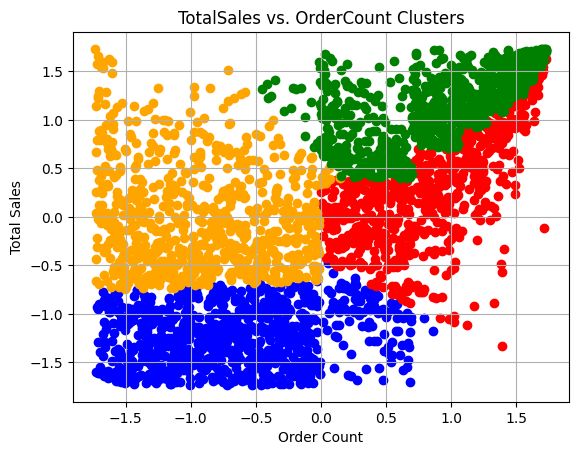

In [11]:
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'],
c='blue')
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'],
c='red')
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'],
c='orange')
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'],
c='green')
plt.title('TotalSales vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Total Sales')
plt.grid()
plt.show()

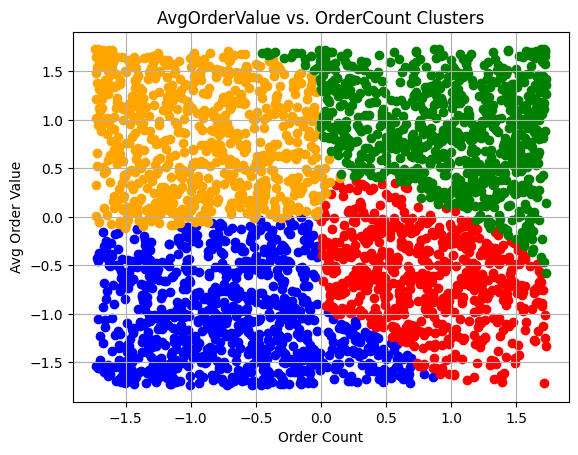

In [12]:
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['OrderCount'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
c='blue')
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['OrderCount'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
c='red')
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['OrderCount'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
c='orange')
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['OrderCount'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
c='green')
plt.title('AvgOrderValue vs. OrderCount Clusters')
plt.xlabel('Order Count')
plt.ylabel('Avg Order Value')
plt.grid()
plt.show()

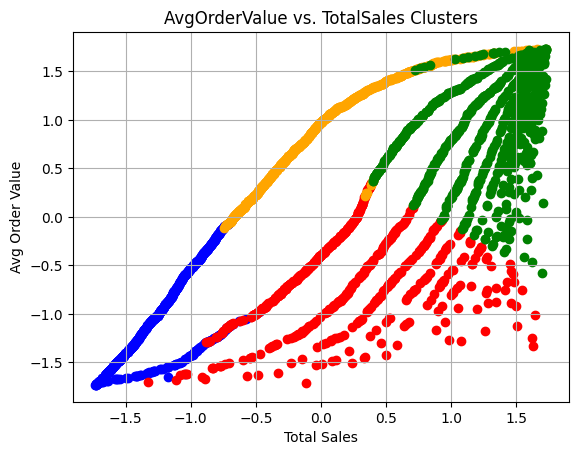

In [13]:
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['TotalSales'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 0]['AvgOrderValue'],
c='blue')
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['TotalSales'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 1]['AvgOrderValue'],
c='red')
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['TotalSales'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 2]['AvgOrderValue'],
c='orange')
plt.scatter(
four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['TotalSales'], 
four_cluster_df.loc[four_cluster_df['Cluster'] == 3]['AvgOrderValue'],
c='green')
plt.title('AvgOrderValue vs. TotalSales Clusters')
plt.xlabel('Total Sales')
plt.ylabel('Avg Order Value')
plt.grid()
plt.show()

In [14]:
high_value_cluster = four_cluster_df.loc[four_cluster_df['Cluster'] == 2]
pd.DataFrame(df.loc[df['CustomerID'].isin(high_value_cluster.index)].groupby(
'Description').count()['StockCode'].sort_values(ascending=False).head())

,StockCode
Description,
WHITE HANGING HEART T-LIGHT HOLDER,106
REGENCY CAKESTAND 3 TIER,100
ASSORTED COLOUR BIRD ORNAMENT,89
SET OF 3 CAKE TINS PANTRY DESIGN,82
BAKING SET 9 PIECE RETROSPOT,77


https://github.com/hyunjoonbok/Python-Projects/blob/master/GeneralML/Cohort_Basket_Analysis/%5BAdvanced%5D%20Cohort%20Analysis%20-%20Customer%20Segmentation%20(1).ipynb